In [2]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, Country, utils

import netCDF4

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

from scipy.interpolate import griddata
from scipy.ndimage import binary_closing

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import roc_auc_score
from skimage import transform

import matplotlib.pyplot as plt

from IPython.display import SVG
import calendar
import os

Using TensorFlow backend.


In [2]:
# TODO: Include Cosine Lattitude Weights!!

In [3]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ERA5_ROOT = os.path.join(DATA_ROOT, 'ERA5')
T2M_PATH = os.path.join(ERA5_ROOT, 't2mmax_US_1979-2018_1jan_31dec_daily_0.25deg.nc')
SST_PATH = os.path.join(ERA5_ROOT, 'sst_1979-2018_1jan_31dec_daily_2.5deg.nc')
LSM_PATH = os.path.join(ERA5_ROOT, 'landseamask_0.25deg.nc')
CLS_PATH = os.path.join(ERA5_ROOT, 'cluster_US.nc')

In [4]:
EXTEND_SUMMER = 0
SUMMER_LEN = 60 + EXTEND_SUMMER * 2

def summer_indices(df: pd.DataFrame, extend: int=0):
    summer = []
    for year in np.unique(df.index.year):
        leap = -1 if calendar.isleap(year) else 0
        summer.append(df.loc[f"{24+leap-extend}-06-{year}":f"{22+leap+extend}-08-{year}"])
    return pd.concat(summer).values.ravel()

In [5]:
# Load Temperature at 2 Metres (T2M) data from disk
# Only load hottest 60 summer days of each year, as defined in summer_indices()
ERA5_KWARGS = {'time_origin': '1979-01-01', 'time_unit': 'D'}
T2M = ERA(T2M_PATH, 't2m', **ERA5_KWARGS)
T2M = ERA(T2M_PATH, 't2m', **ERA5_KWARGS, index=[summer_indices(T2M.time, EXTEND_SUMMER)])

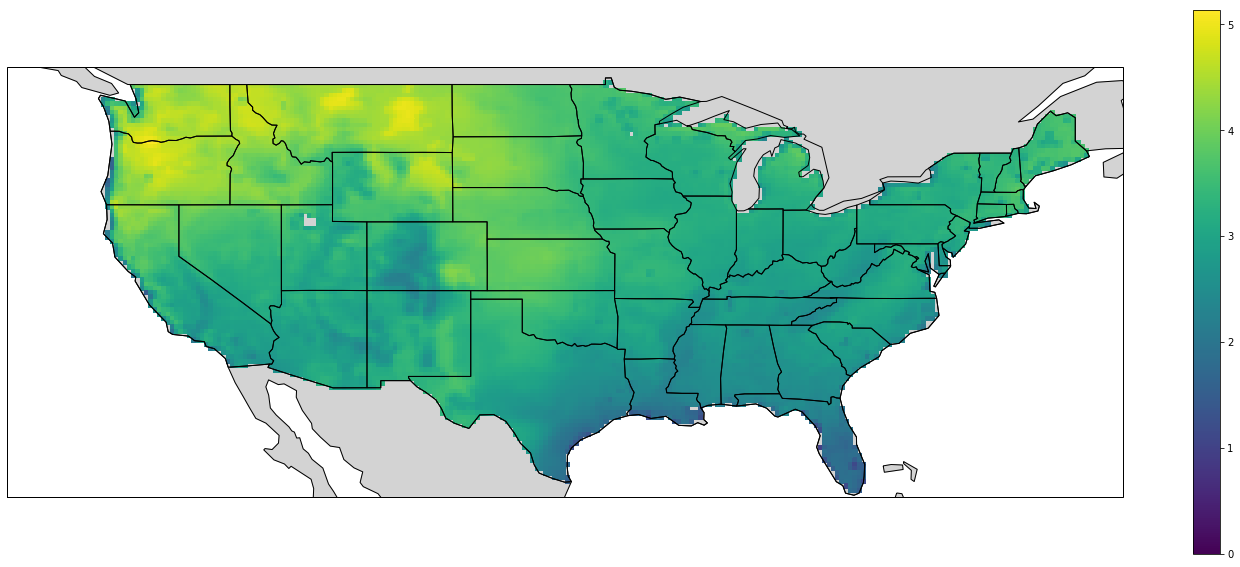

In [15]:
LSM_THRESHOLD = 0.5

# Mask US (Data is already bounded for US Mainland)
# This calculation can take a while the first time, but will be buffered..
MASK_US = binary_closing(utils.era_country_mask(T2M_PATH) == Country.US)

# Calculate Land-Sea Mask
LSM = ERA(LSM_PATH, 'lsm')
LSM = ERA(LSM_PATH, 'lsm', index=[
    None,
    slice(np.where(LSM.latitude == T2M.latitude[0])[0][0], np.where(LSM.latitude == T2M.latitude[-1])[0][0] + 1),
    slice(np.where(LSM.longitude == T2M.longitude[0] + 360)[0][0], np.where(LSM.longitude == T2M.longitude[-1] + 360)[0][0] + 1)
]).data[0]

MASK_US *= LSM >= LSM_THRESHOLD

tmp = np.std(T2M.data, 0)
tmp[~MASK_US] = np.nan

utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, tmp, vmin=0)
plt.colorbar()
plt.show()

del LSM, tmp

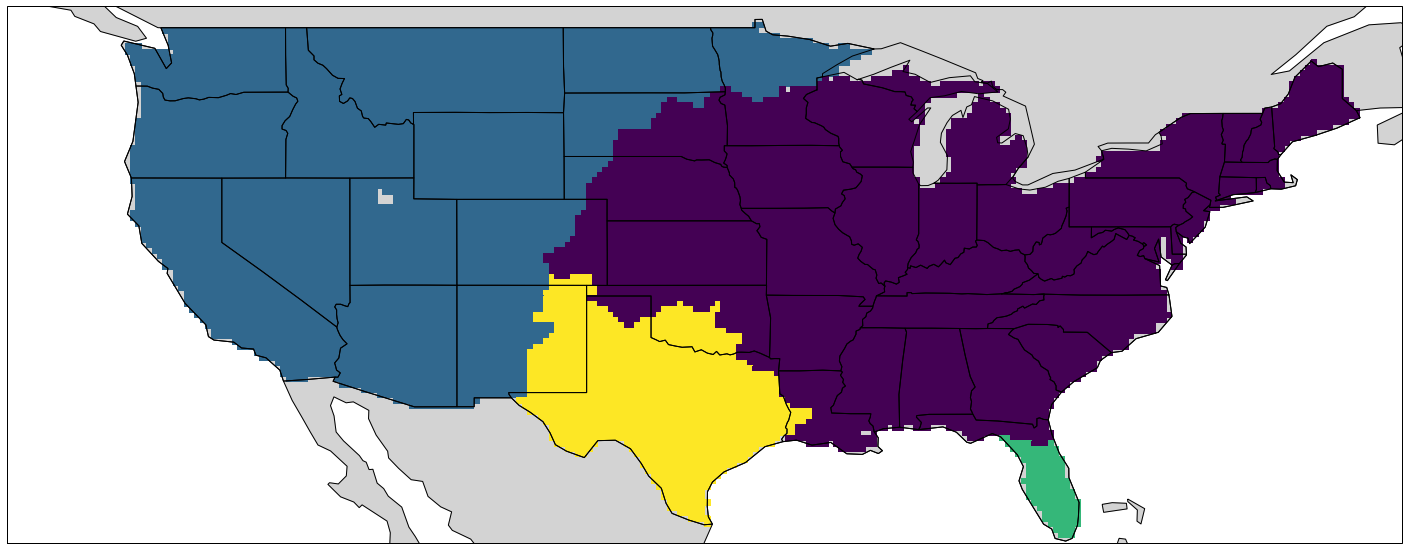

In [7]:
N = 4  # Number of Clusters

T2M_US = T2M.data[:, MASK_US]
T95_BOOL = T2M_US > np.quantile(T2M_US, 0.95, 0)

# Create Clustering to find Eastern United States
cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
cluster.fit(T95_BOOL.T)

# Create 2D Label Array
labels = np.empty(T2M.data.shape[1:])
labels.fill(np.nan)
labels[MASK_US] = cluster.labels_

# Find East Cluster (by looking at the maximum longitude value of each cluster and taking the max of that)
east_index = np.argmax([np.max(np.argwhere(labels==label)[:, 1]) for label in np.unique(labels[~np.isnan(labels)])])
east_mask = labels == east_index

# Plot Clusters
projection = utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, labels)
plt.show()

In [8]:
KFOLDS = 4

# Get Unique Years
YEARS = np.unique(T2M.time.index.year)

# Make 'KFOLDS' groups of years, each group will be a test set
TEST_YEARS = [years.tolist() for years in np.split(YEARS, KFOLDS)]

INDICES = []

for test_years in TEST_YEARS:
    
    INDICES.append([[], []])
    
    for year in YEARS:
        indices = T2M.time[str(year)].values.ravel()
        
        if year in test_years:
            INDICES[-1][1].append(indices)
        else:
            INDICES[-1][0].append(indices)
            
    INDICES[-1][0] = np.concatenate(INDICES[-1][0])
    INDICES[-1][1] = np.concatenate(INDICES[-1][1])

In [9]:
T95 = []

# Define T95 for each fold
for train_indices, test_indices in INDICES:
    # Load Train and Test Temperature at 2 Metres (T2M) Data
    T2M_US_EAST_TRAIN = T2M.data[train_indices][:, east_mask].reshape(len(train_indices)//SUMMER_LEN, SUMMER_LEN, -1)
    T2M_US_EAST_TEST = T2M.data[test_indices][:, east_mask].reshape(len(test_indices)//SUMMER_LEN, SUMMER_LEN, -1)
    
    # Calculate daily mean and standard deviation on train set
    T2M_US_EAST_TRAIN_MEAN = T2M_US_EAST_TRAIN.mean(0, keepdims=True)
    
    # Calculate Anomalies based on train mean per day
    T2M_US_EAST_ANOMALY_TRAIN = T2M_US_EAST_TRAIN - T2M_US_EAST_TRAIN_MEAN
    T2M_US_EAST_ANOMALY_TEST = T2M_US_EAST_TEST - T2M_US_EAST_TRAIN_MEAN
    
    # Calculate Spatial 95th percentile
    T95_TRAIN = np.quantile(T2M_US_EAST_ANOMALY_TRAIN, 0.95, -1).ravel()
    T95_TEST = np.quantile(T2M_US_EAST_ANOMALY_TEST, 0.95, -1).ravel()
    
    # Normalize Timeseries
    T95_TRAIN_MEAN = np.mean(T95_TRAIN)
    T95_TRAIN_STD = np.std(T95_TRAIN)
    
    T95_TRAIN = (T95_TRAIN - T95_TRAIN_MEAN) / T95_TRAIN_STD
    T95_TEST = (T95_TEST - T95_TRAIN_MEAN) / T95_TRAIN_STD
    
    T95.append((
        pd.DataFrame(T95_TRAIN, index=T2M.time.index[train_indices]),
        pd.DataFrame(T95_TEST, index=T2M.time.index[test_indices])
    ))

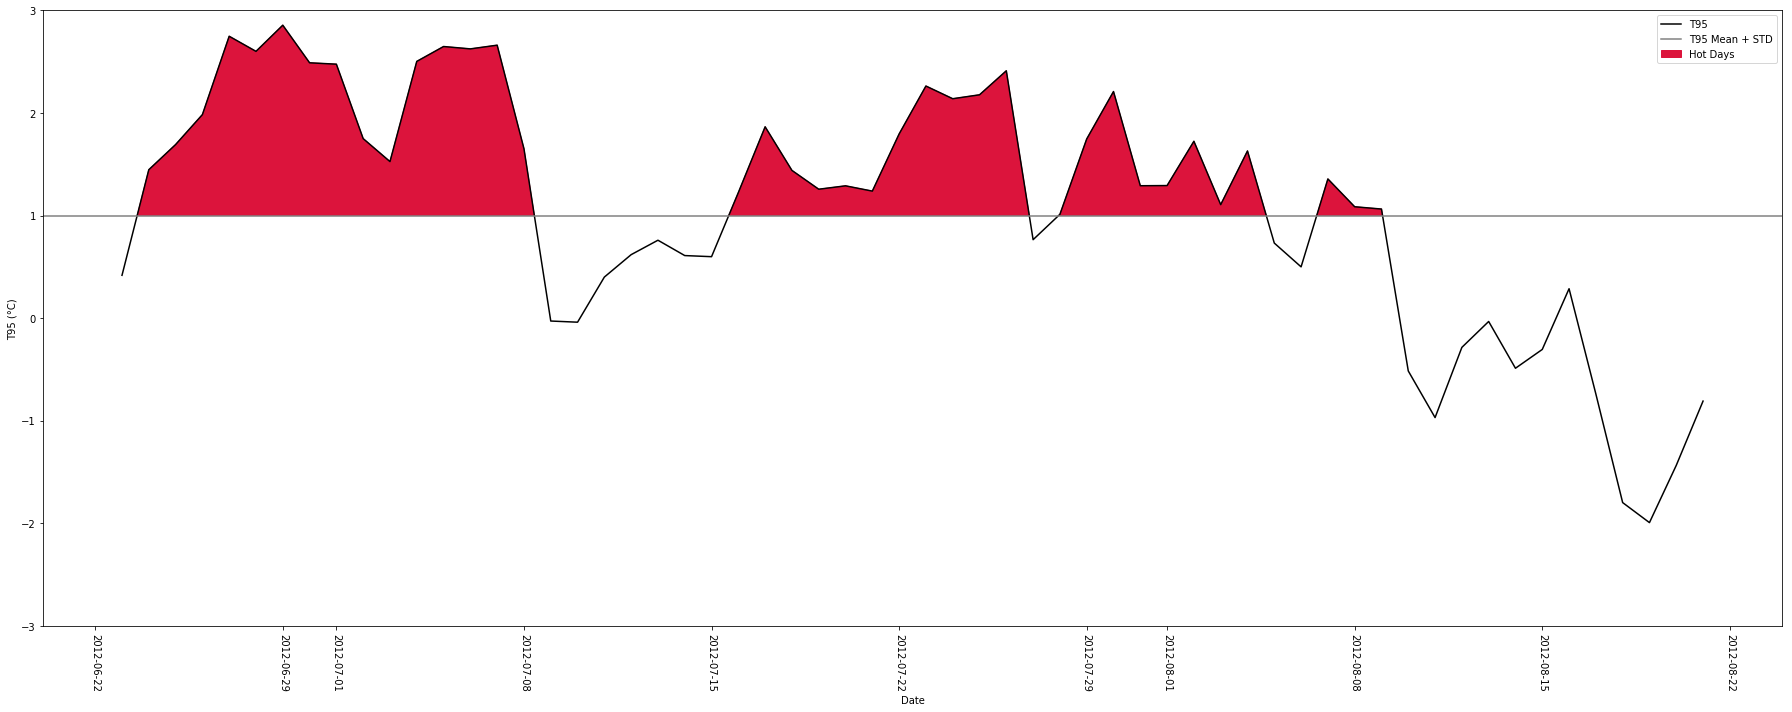

In [10]:
PLOT_YEAR = 2012
PLOT_T95 = T95[0][0][str(PLOT_YEAR)]

plt.plot(PLOT_T95, c="black", label="T95")
plt.axhline(1, c="gray", label="T95 Mean + STD")
plt.fill_between(PLOT_T95.index, [1]*len(PLOT_T95), PLOT_T95.values.ravel(),
                where=PLOT_T95.values.ravel() > 1, interpolate=True, color='crimson',
                label="Hot Days")
plt.ylabel("T95 (°C)")
plt.ylim(-3, 3)
plt.xlabel("Date")
plt.xticks(rotation=-90)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
LAG = 50

SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS)
SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS, index=[summer_indices(T2M.time, EXTEND_SUMMER) - LAG])

# Plot Anomaly Standard Deviations
projection = utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, np.std(SST.data, 0), cmap='coolwarm', vmin=0)
plt.colorbar()
plt.show()

SST_WEIGHT = np.repeat(np.cos(np.deg2rad(SST.latitude))[:, None, None], len(SST.longitude), axis=1)

NameError: name 'SST_PATH' is not defined

In [92]:
SST_ANOMALY = []

for train_indices, test_indices in INDICES:
    
    # Load Sea Surface Temperature (SST) data for Train and Test for this fold
    SST_TRAIN = SST.data[train_indices].reshape(len(train_indices)//60, 60, len(SST.latitude), len(SST.longitude))
    SST_TEST = SST.data[test_indices].reshape(len(test_indices)//60, 60, len(SST.latitude), len(SST.longitude))
    
    # Calculate Mean and Standard Deviation for Train Set
    SST_MEAN_TRAIN = SST_TRAIN.mean(0, keepdims=True)
    SST_STD_TRAIN = SST_TRAIN.std(0, keepdims=True)
    
    # Compute Normalized Anomalies for Train & Test, based on Train Statistics
    SST_ANOMALY_TRAIN = (SST_TRAIN - SST_MEAN_TRAIN) / SST_STD_TRAIN
    SST_ANOMALY_TEST = (SST_TEST - SST_MEAN_TRAIN) / SST_STD_TRAIN
    
    # Assign 0 anomaly to Land Area's (Replace NaN with 0)
    SST_ANOMALY_TRAIN[np.isnan(SST_ANOMALY_TRAIN)] = 0
    SST_ANOMALY_TEST[np.isnan(SST_ANOMALY_TEST)] = 0
    
    SST_ANOMALY.append((
        SST_ANOMALY_TRAIN.reshape(-1, len(SST.latitude), len(SST.longitude), 1),
        SST_ANOMALY_TEST.reshape(-1, len(SST.latitude), len(SST.longitude), 1)
    ))

In [1]:
# CNN Hyperparameters #

LOSS = 'binary_crossentropy'
OPTIMIZER = 'adam'
ACTIVATION = tf.nn.relu
ACTIVATION_OUTPUT = tf.nn.sigmoid
REGULARIZER = keras.regularizers.l2(0.05)
CONVOLUTION_KWARGS = {'kernel_size': 3, 'padding': 'same', 'kernel_regularizer': REGULARIZER}

# Model Creation #
def model():
    
    # Sequential Model
    model = keras.models.Sequential()
    
    # Input Layer (Specifying Input Shape here, hacky and nice!)
    model.add(keras.layers.Activation('linear', input_shape=(len(SST.latitude), len(SST.longitude), 1)))
    
    def convolution(filters: int, n: int, dropout: float = 0.0):
        for i in range(n):
            model.add(keras.layers.Convolution2D(filters, **CONVOLUTION_KWARGS))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(ACTIVATION))
            
        model.add(keras.layers.MaxPooling2D(2))
        
        if dropout:
            model.add(keras.layers.Dropout(dropout))
            
    def dense(units: int, dropout: float = 0.0):
        model.add(keras.layers.Dense(units, kernel_regularizer=REGULARIZER))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
        if dropout:
            model.add(keras.layers.Dropout(dropout))
    
    convolution(1, 2, 0.1)
    convolution(2, 2, 0.2)
    convolution(4, 1, 0.3)
    
    model.add(keras.layers.Flatten())
    
    dense(100, 0.5)
    
    model.add(keras.layers.Dense(1, activation=ACTIVATION_OUTPUT, name="output"))
    model.compile(loss=LOSS, optimizer=OPTIMIZER)
    
    return model
    
model().summary()

NameError: name 'tf' is not defined

((1800, 44, 144, 1), (1800, 1)) ((600, 44, 144, 1), (600, 1))
Train on 1800 samples, validate on 600 samples
Epoch 1/20
1800/1800 [==============================] - 14s 8ms/step - loss: 18.4707 - val_loss: 8.0256
 -> AUC: 0.6222999159823293 0.6065777315777315


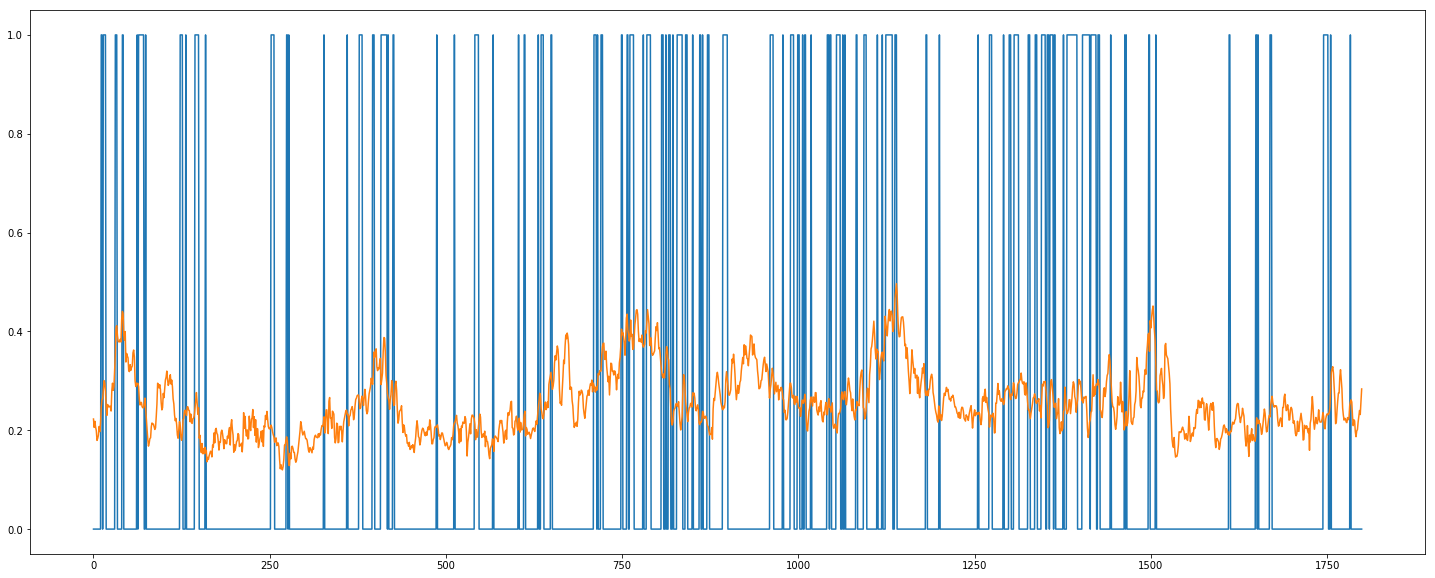

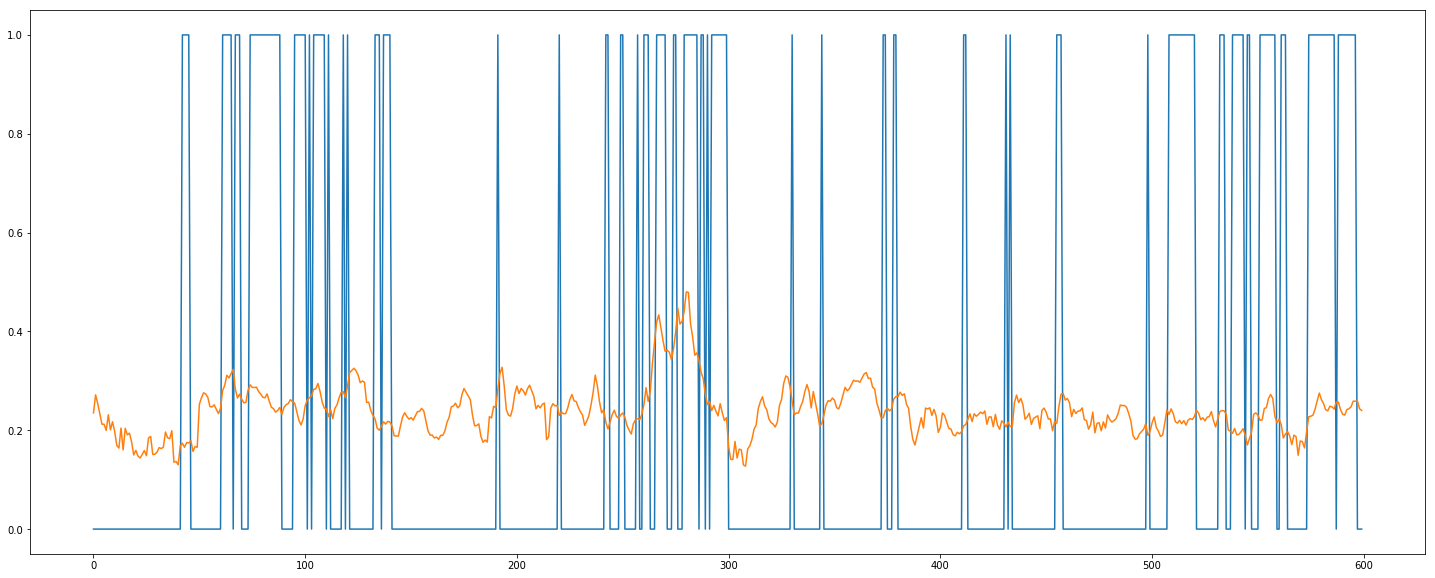

Epoch 2/20
1800/1800 [==============================] - 5s 3ms/step - loss: 4.5985 - val_loss: 2.7846
 -> AUC: 0.6308496174034023 0.563539501039501


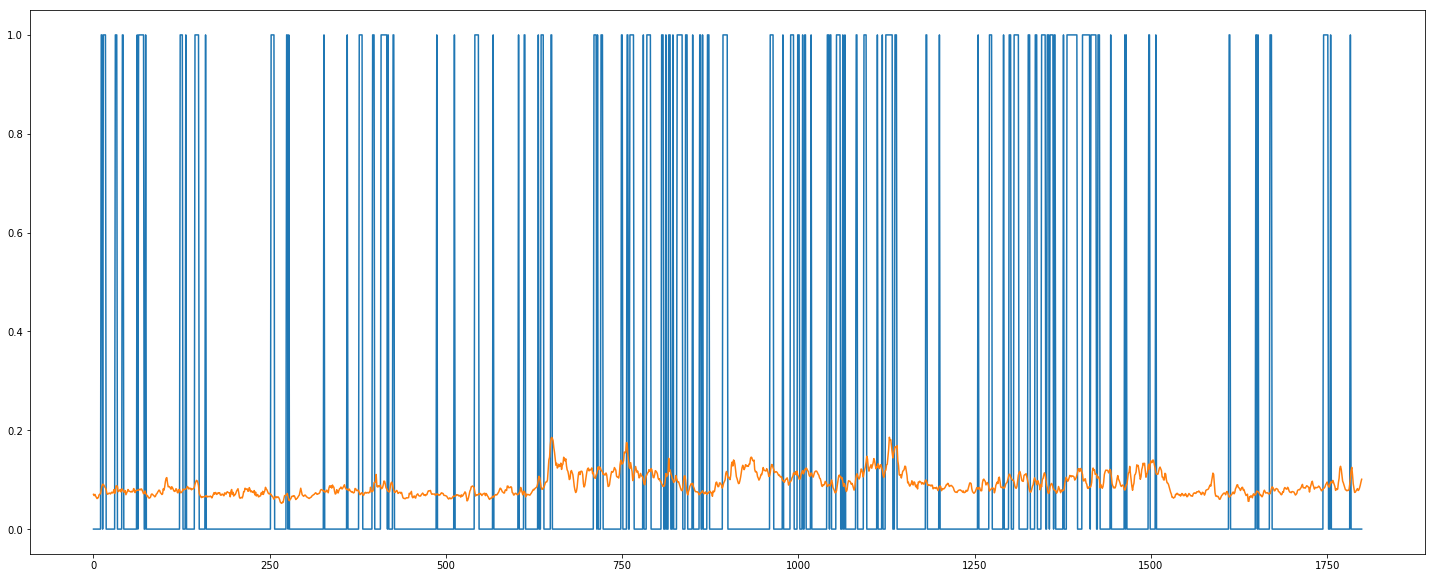

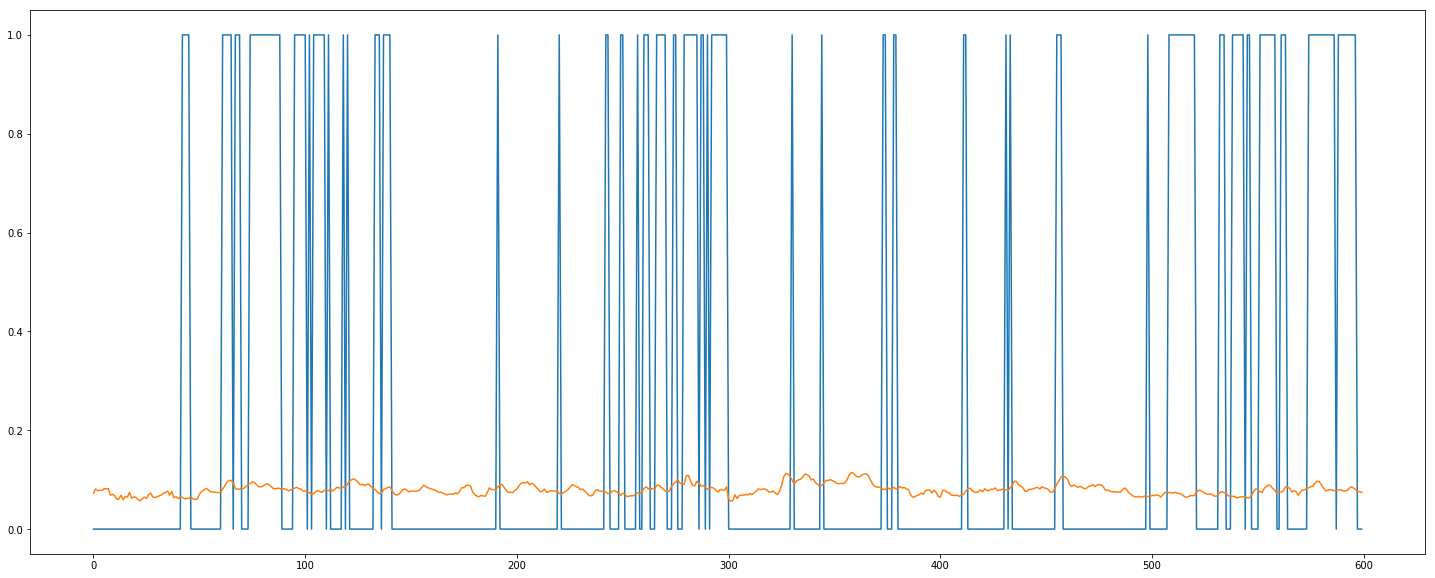

Epoch 3/20
1800/1800 [==============================] - 5s 3ms/step - loss: 1.9328 - val_loss: 1.8233
 -> AUC: 0.6294685204759195 0.4453540078540079


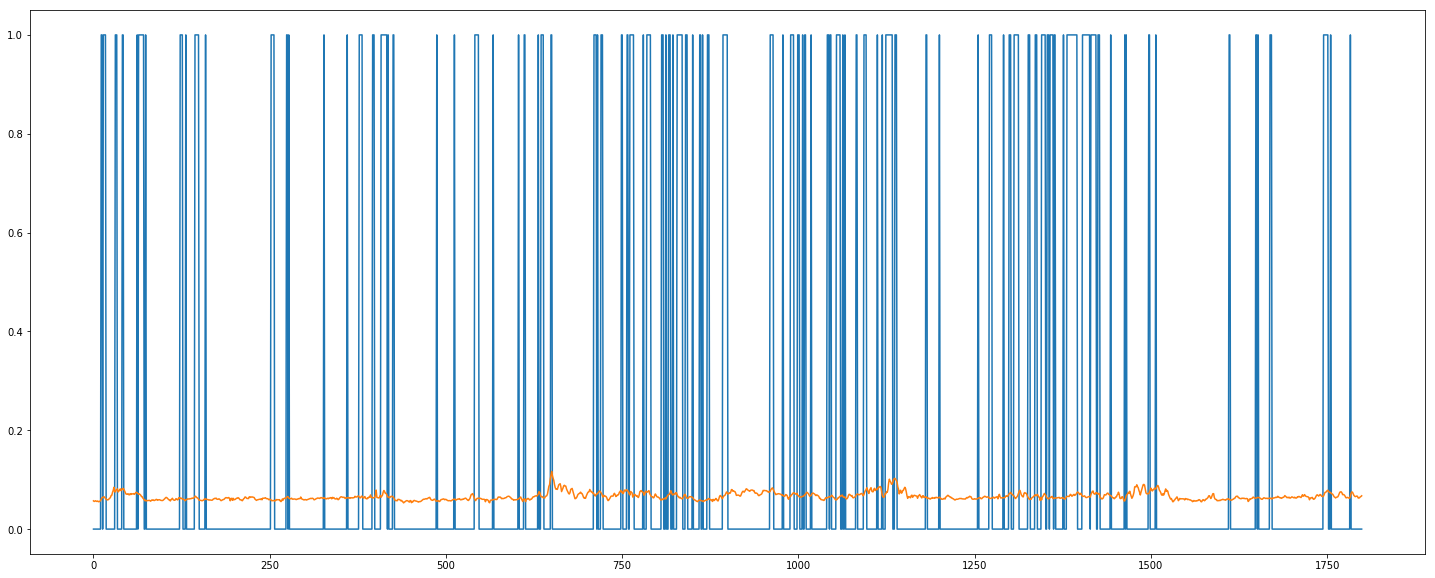

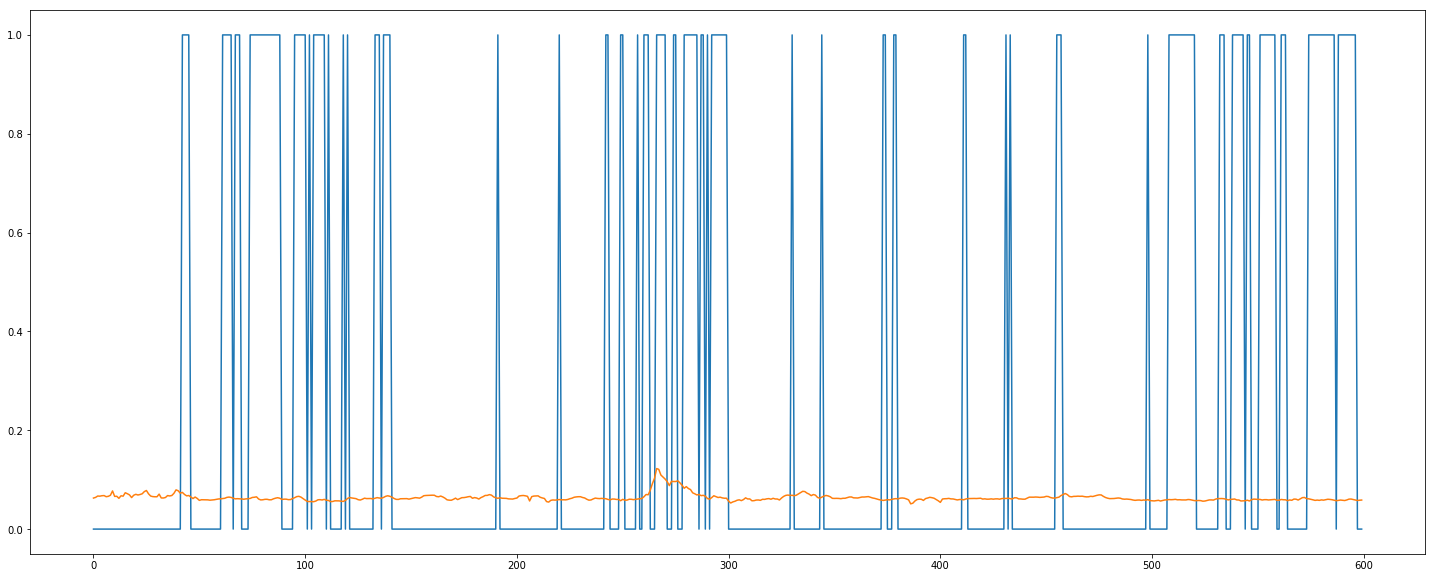

Epoch 4/20
1800/1800 [==============================] - 5s 3ms/step - loss: 1.3720 - val_loss: 1.5184
 -> AUC: 0.6165248303836807 0.4527315777315778


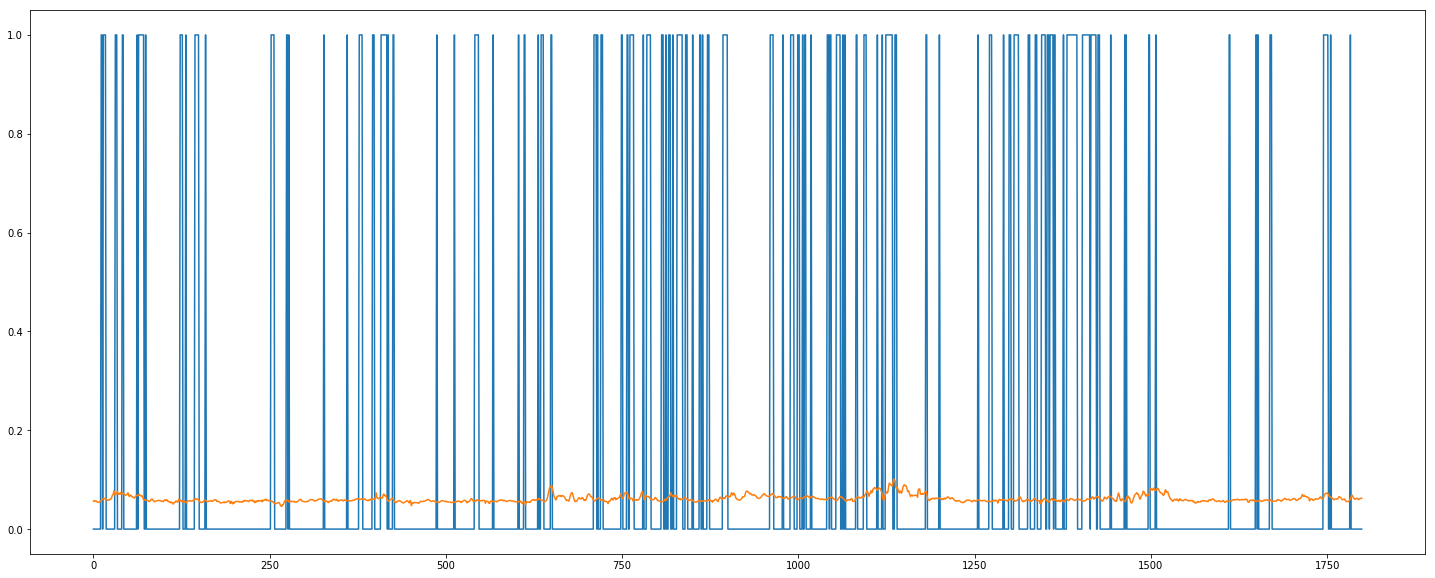

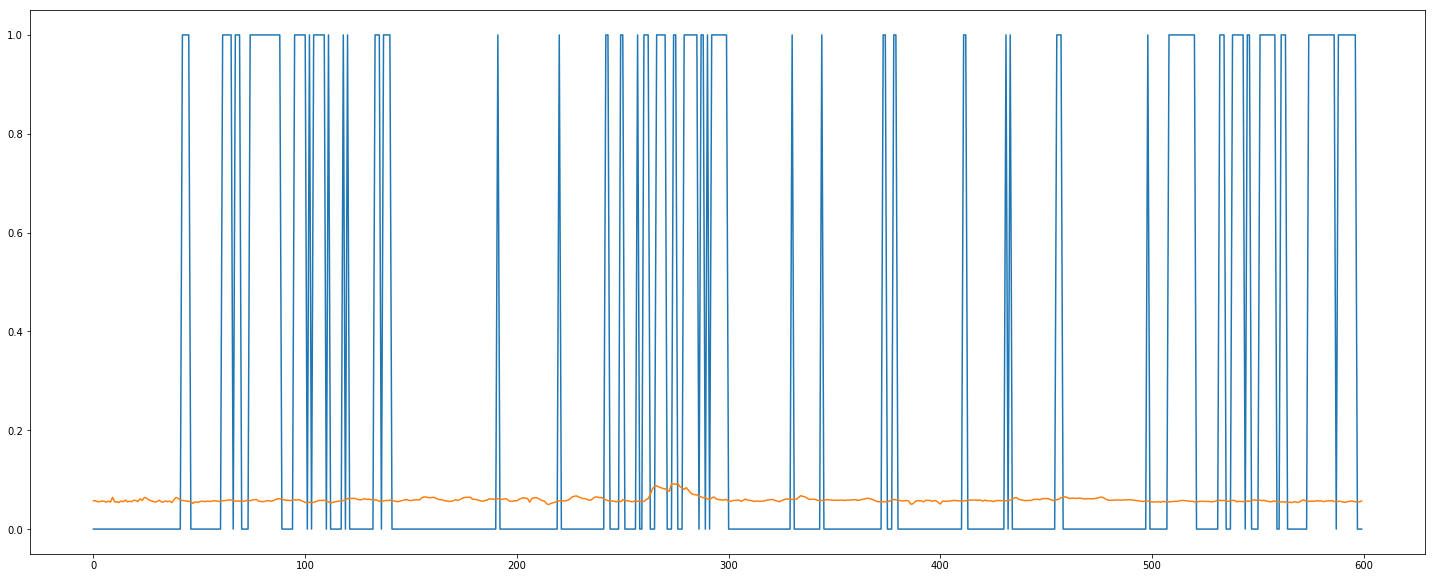

Epoch 5/20
1800/1800 [==============================] - 5s 3ms/step - loss: 1.1145 - val_loss: 1.4553
 -> AUC: 0.6060745679413864 0.3457207207207207


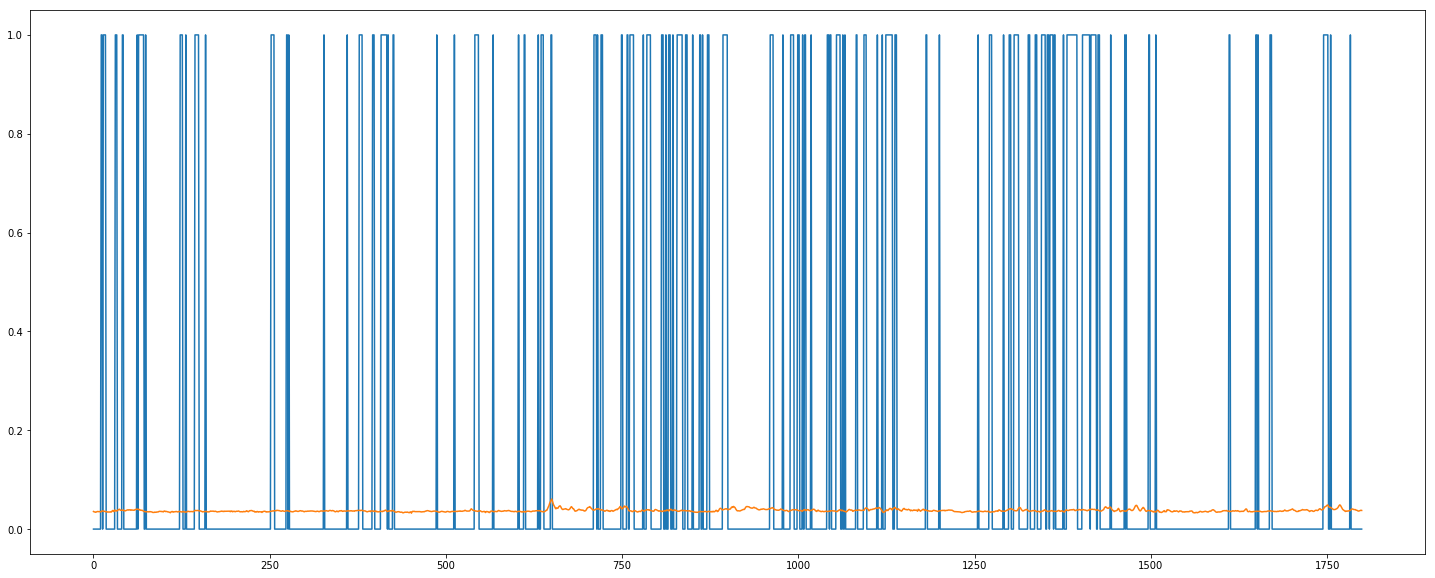

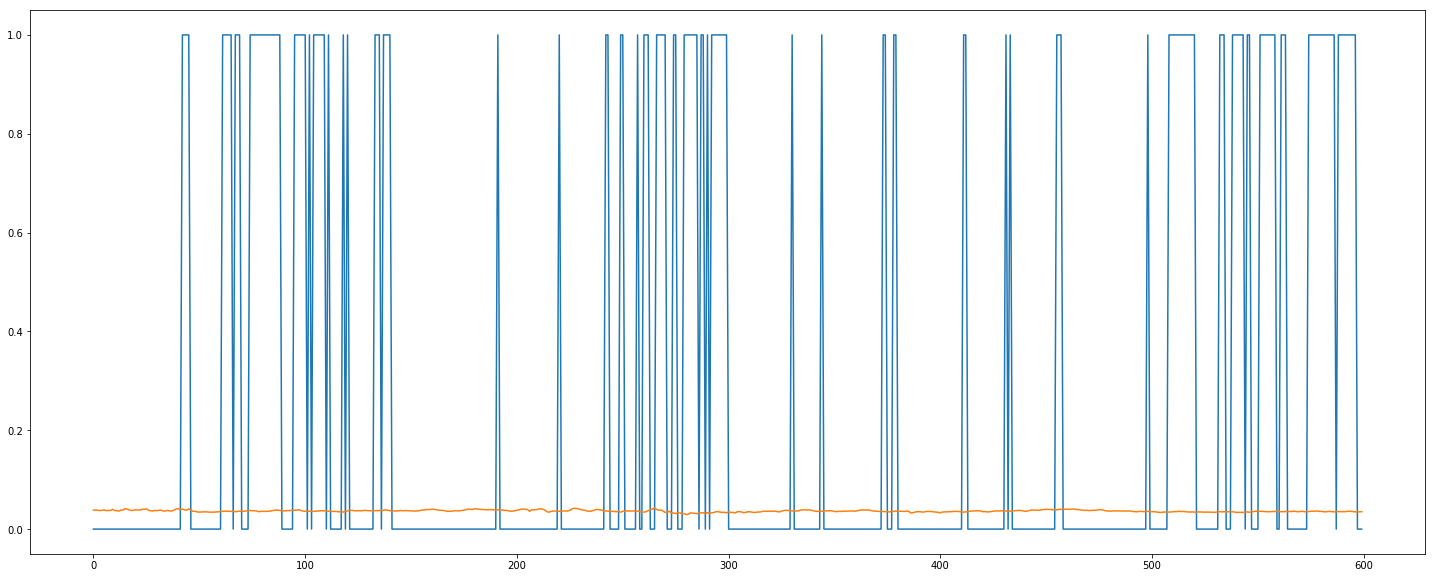

Epoch 6/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.9478 - val_loss: 1.2914
 -> AUC: 0.5460346821331454 0.43430209055209057


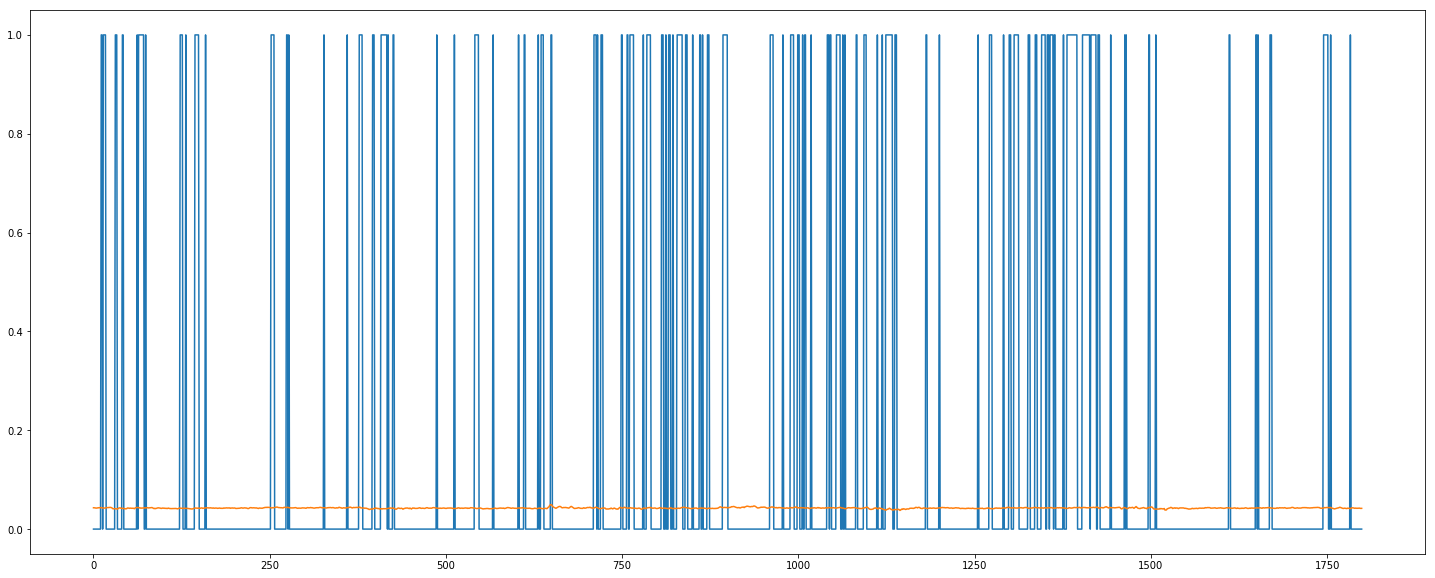

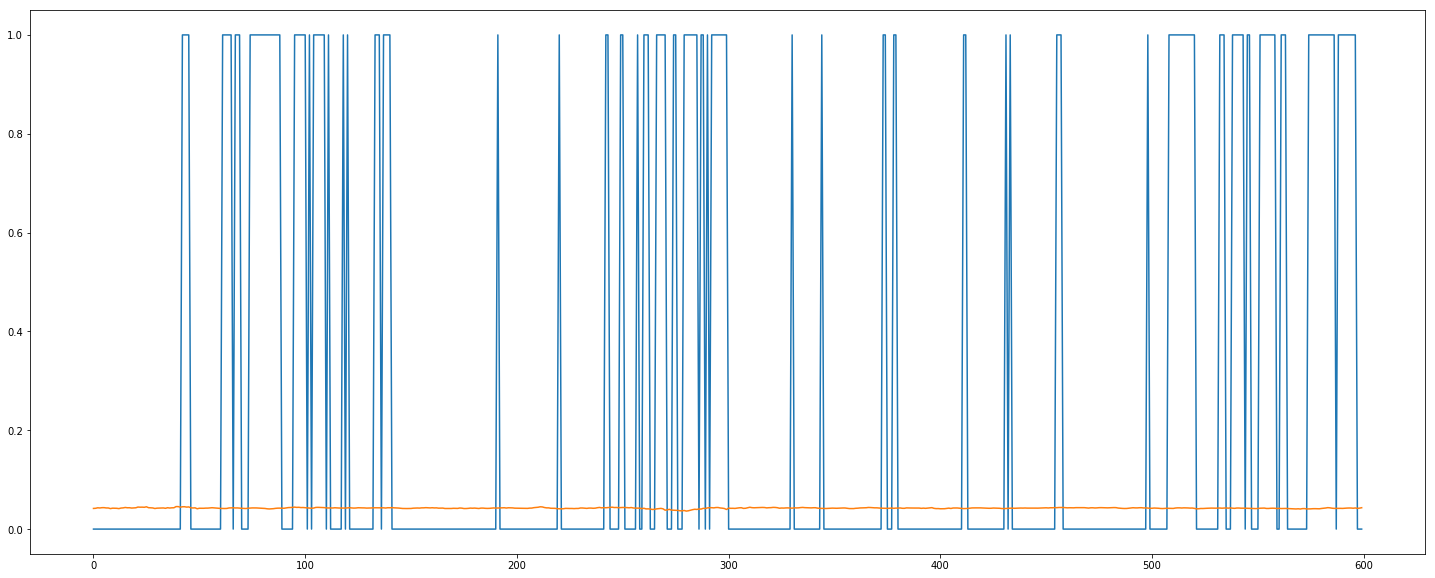

Epoch 7/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.8542 - val_loss: 1.3158
 -> AUC: 0.5981629039397963 0.5416594479094479


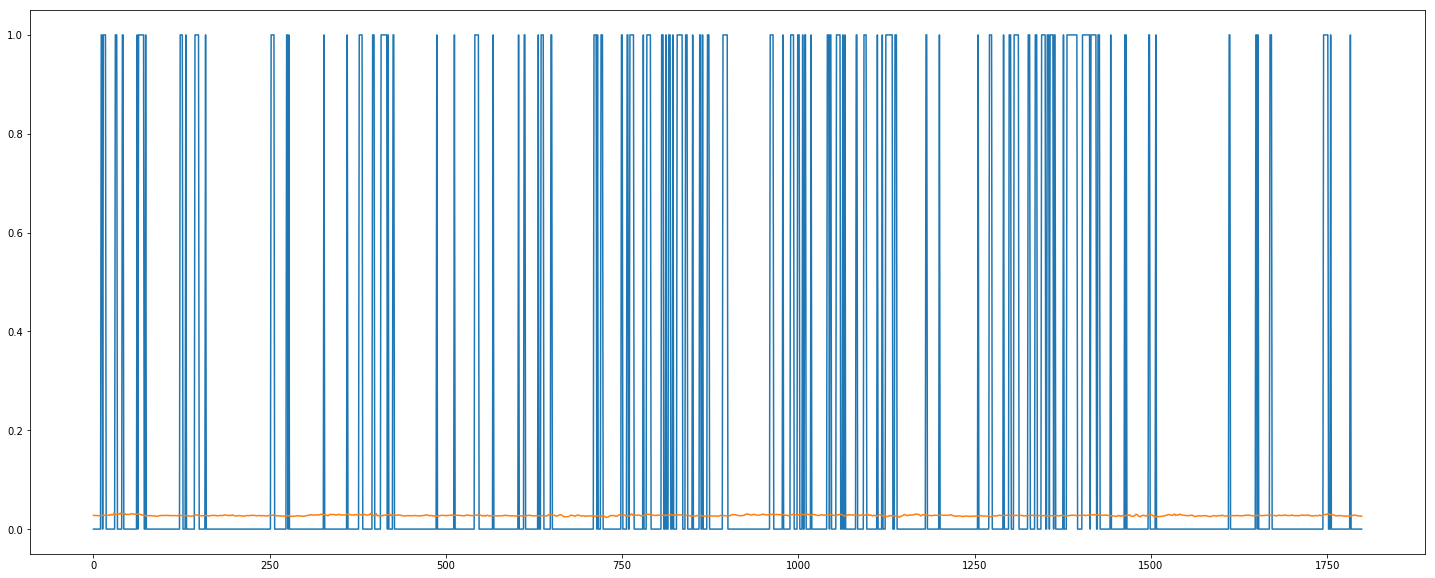

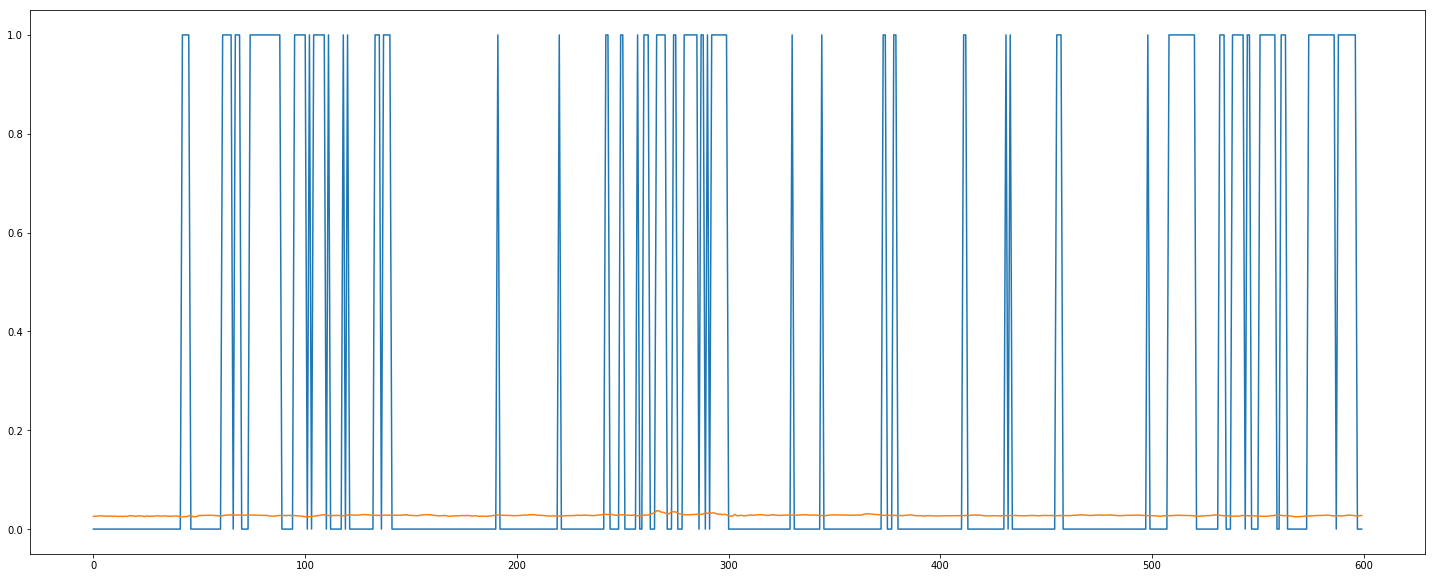

Epoch 8/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.7639 - val_loss: 1.2068
 -> AUC: 0.6463748181875671 0.5198804573804574


KeyboardInterrupt: 

In [ ]:
for (X_train, X_test), (y_train, y_test) in zip(SST_ANOMALY, T95):
    print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))
    
    # Make Binary Labels
    y_train = (y_train > 1).values
    y_test = (y_test > 1).values
    
    class Callback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            print(" -> AUC:",
                  roc_auc_score(y_train, self.model.predict(X_train)),
                  roc_auc_score(y_test, self.model.predict(X_test)))
            
            plt.plot(y_train)
            plt.plot(self.model.predict(X_train))
            plt.show()
            
            plt.plot(y_test)
            plt.plot(self.model.predict(X_test))
            plt.show()
    
    cnn = model()
    cnn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[Callback()],
           shuffle=True, epochs=20)
    
    break # Only train one fold for now

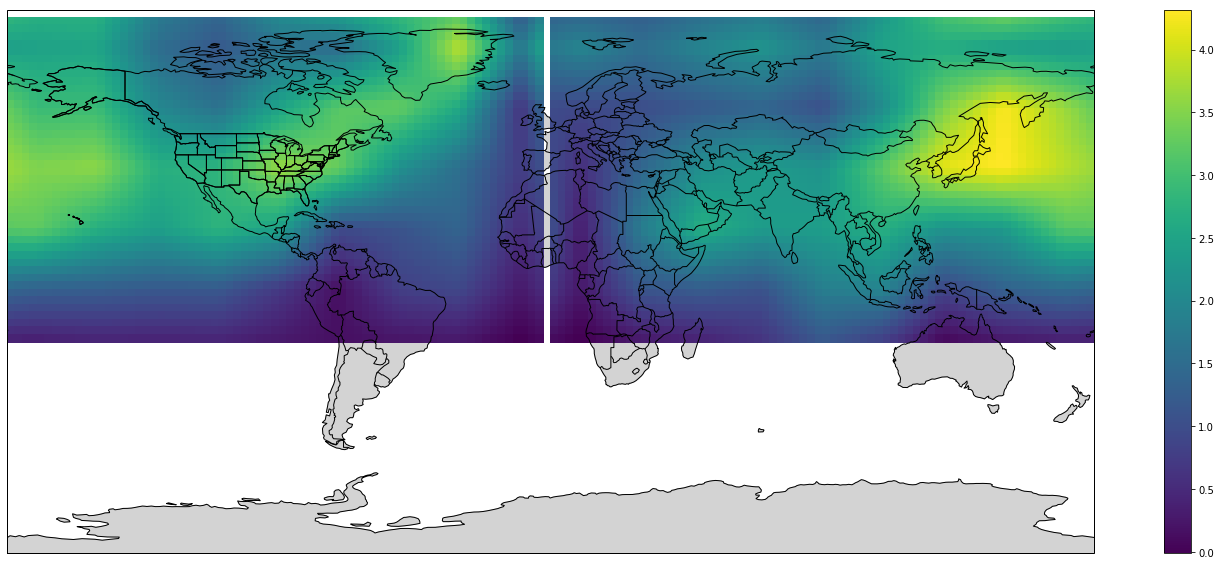

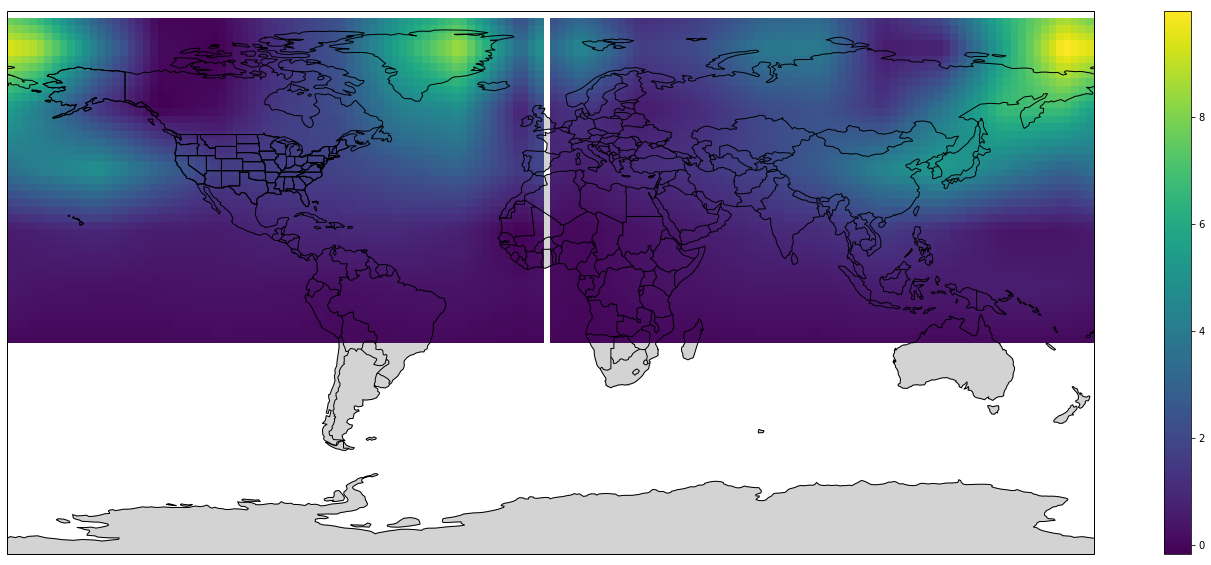

In [81]:
# Class Activation Map
def CAM(model, X):
    
    last_convolution = [layer for layer in model.layers if isinstance(layer, keras.layers.Convolution2D)][-1]
    result = np.zeros(last_convolution.output.shape[1:-1])
    
    gradients = keras.backend.gradients(model.output, last_convolution.output)[0]
    gradients_mean = keras.backend.mean(gradients, axis=(0, 1, 2))
    iterate = keras.backend.function([model.input], [gradients_mean, last_convolution.output[0]])

    for counter, x in enumerate(X):
        activation, output = iterate([x[None, ...]])
        for i in range(gradients_mean.shape[0]):
            output[..., i] += activation[i]
            
        result += output.mean(-1)
    
    return transform.resize(result, X.shape[1:-1])

# Train Activation
utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, CAM(cnn, X_train[y_train.ravel()])[:-4])
plt.colorbar()
plt.show()

# Test Activation
utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, CAM(cnn, X_test[y_test.ravel()])[:-4])
plt.colorbar()
plt.show()